# Heterogeneous Autoregressive model

The HAR model assumes that the volatility (or other financial variables) is driven by components at different time scales (long-term, medium-term, and short-term).

## Import Packages and Dataset

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [9]:
# The dataset contains 2019 observations and 9 columns.
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.set_index(df.columns[0], inplace=True)
df.head()

,open,high,low,close,return,return2,RV,lnRV,lnRV_lag1,lnRV_5D_lag,lnRV_7D_lag,lnRV_22D_lag,lnRV_30D_lag,lnRV_60D_lag
timestamp,,,,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.015681,0.020962,-3.865058,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.097191,0.025926,-3.652501,-3.865058,NaN,NaN,NaN,NaN,NaN
2019-06-25,1.417,1.920,1.314,1.540,0.083946,0.007047,0.042346,-3.161881,-3.652501,NaN,NaN,NaN,NaN,NaN
2019-06-26,1.538,1.875,1.457,1.595,0.035091,0.001231,0.035729,-3.331801,-3.161881,NaN,NaN,NaN,NaN,NaN
2019-06-27,1.595,1.597,1.371,1.419,-0.116921,0.013671,0.019125,-3.956779,-3.331801,NaN,NaN,NaN,NaN,NaN


In [11]:
# create lag terms of lnRV
df.dropna(inplace=True)
df.head(2)

,open,high,low,close,return,return2,RV,lnRV,lnRV_lag1,lnRV_5D_lag,lnRV_7D_lag,lnRV_22D_lag,lnRV_30D_lag,lnRV_60D_lag
timestamp,,,,,,,,,,,,,,
2019-08-22,0.567,0.592,0.531,0.572,0.008780,0.000077,0.006631,-5.015983,-5.177089,-5.334462,-5.232313,-4.837572,-4.847512,-4.692676
2019-08-23,0.573,0.589,0.546,0.576,0.006969,0.000049,0.005480,-5.206578,-5.015983,-5.246696,-5.275639,-4.806067,-4.863660,-4.711858


## Train Test Split

In [35]:
# split train and test data
df_train = df.loc[:'2024-01-01']
df_test = df.loc['2024-01-01':]

In [40]:
date_ticks = ['2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-01']

## Basic HAR Model

$$
lnRV_t = \alpha + \beta_1 lnRV_{t-1} + \beta_2 lnRV_{5D, t-1} + \beta_3 lnRV_{22D, t-1} + \epsilon_t
$$
Where:
- $lnRV_t$ is the dependent variable (e.g., log realised volatility of return) at time \( t \).
- $\alpha$ is a constant term.
- $\beta_1, \beta_2, \beta_3$ are the coefficients for different time lags.
- $lnRV_{5D, t-1}$ and $lnRV_{22D, t-1}$ are the 1-day lag of the average log realised volatility of return over the past 5 days and 22 days respectively.
- $\epsilon_t$ is the error term.

In [54]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag1', 'lnRV_5D_lag', 'lnRV_22D_lag']]
y_test = df_test['lnRV']
X_test = df_test[['lnRV_lag1', 'lnRV_5D_lag', 'lnRV_22D_lag']]

In [55]:
# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1129.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:56:16   Log-Likelihood:                -1220.8
No. Observations:                1594   AIC:                             2450.
Df Residuals:                    1590   BIC:                             2471.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4366      0.105     -4.144   

In [56]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
y_pred = pd.DataFrame(y_pred, columns=['HAR(1,5,22)'])
y_pred.to_csv('../res/pred.csv')

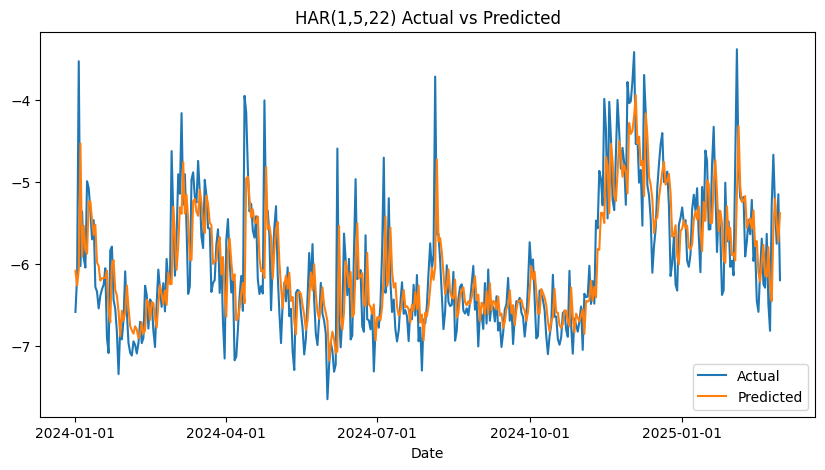

In [65]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,5,22) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,5,22)_Actual_vs_Predicted.png')

## Modified HAR Model

$$
lnRV_t = \alpha + \beta_1 lnRV_{t-1} + \beta_2 lnRV_{7D, t-1} + \beta_3 lnRV_{30D, t-1} + \epsilon_t
$$
Where:
- $lnRV_t$ is the dependent variable (e.g., log realised volatility of return) at time \( t \).
- $\alpha$ is a constant term.
- $\beta_1, \beta_2, \beta_3$ are the coefficients for different time lags.
- $lnRV_{7D, t-1}$ and $lnRV_{30D, t-1}$ are the 1-day lag of the average log realised volatility of return over the past 7 days and 30 days respectively.
- $\epsilon_t$ is the error term.

In [57]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag1', 'lnRV_7D_lag', 'lnRV_30D_lag']]
y_test = df_test['lnRV']
X_test = df_test[['lnRV_lag1', 'lnRV_7D_lag', 'lnRV_30D_lag']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1130.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:56:32   Log-Likelihood:                -1220.0
No. Observations:                1594   AIC:                             2448.
Df Residuals:                    1590   BIC:                             2470.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3993      0.109     -3.674   

In [62]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
df_pred = pd.read_csv('../res/pred.csv')
df_pred['HAR(1,7,30)'] = y_pred.values
df_pred.to_csv('../res/pred.csv')

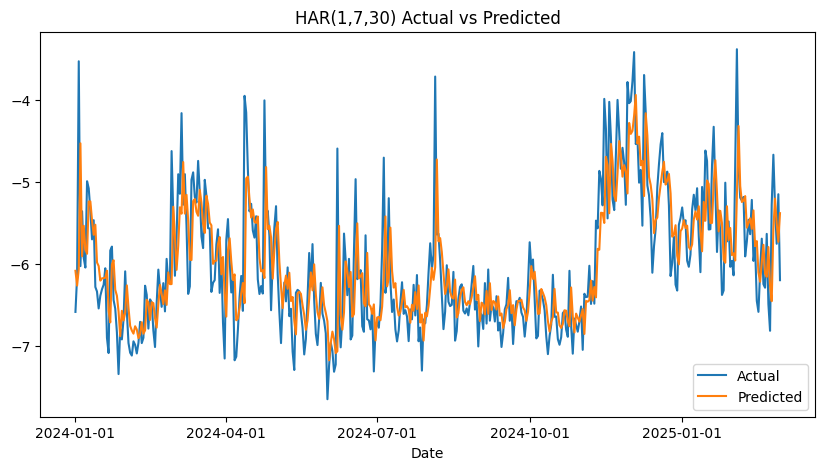

In [64]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,7,30) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,7,30)_Actual_vs_Predicted.png')